In [68]:
import pandas as pd

ASSETS = ['../assets/BTCUSDC.csv', '../assets/ETHUSDC.csv', '../assets/DOGEUSDC.csv', '../assets/SOLUSDC.csv', '../assets/XRPUSDC.csv']
PERIOD_LENGTH_halfhours = 2
PERIOD_START = pd.Timestamp(year=2024, month=8, day=1, tz='UTC')
PERIOD_END = pd.Timestamp(year=2025, month=1, day=1, tz='UTC')

C:\Users\ic2594\AppData\Local\Temp\ipykernel_284\628993961.py:39: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.xticks(pd.date_range(start=pd.to_datetime(min_time, unit='us'),


<module 'matplotlib.pyplot' from 'c:\\Users\\ic2594\\AppData\\Local\\miniconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

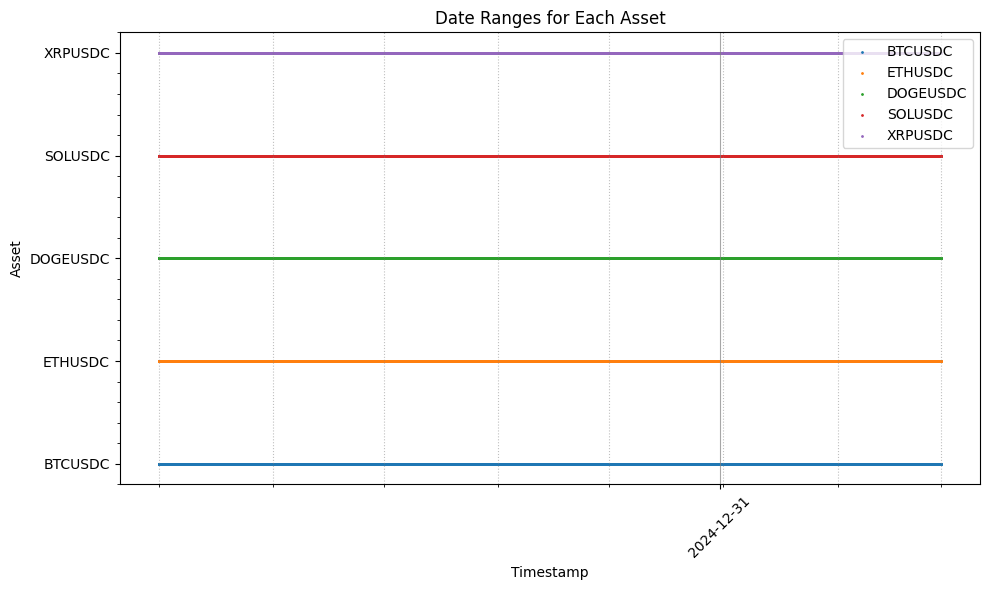

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Load all dataframes and extract the time columns
time_columns = []
merged_dfs = []
tickers = []

min_time = np.inf
max_time = 0
for asset in ASSETS:
    df = pd.read_csv(asset)
    asset = asset.split('/')[-1].split('.')[0]  # Extract asset name from file path
    tickers.append(asset)
    df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: int(f"{x}000") if len(str(x)) == 13 else x)
    df = df.sort_values(by=df.columns[0])
    df['Asset'] = asset  # Add a column with the asset name

    df = df[df.iloc[:, 0] >= PERIOD_START.timestamp() * 1e6]  # Filter by start time

    min_time = min(min_time, df.iloc[0, 0])
    max_time = max(max_time, df.iloc[-1, 0])

    merged_dfs.append(df)
    time_columns.append(set(df.iloc[:, 0]))


# Create a plot for the date ranges of each asset
plt.figure(figsize=(10, 6))
for asset, df in zip(tickers, merged_dfs):
    asset_times = pd.to_datetime(df.iloc[:, 0], unit='us')
    plt.scatter(asset_times, [asset] * len(asset_times), label=asset, s=1)

plt.xlabel("Timestamp")
plt.ylabel("Asset")
plt.title("Date Ranges for Each Asset")
plt.grid(axis='x', which='major', linestyle='-', color='gray', alpha=0.7)
plt.xticks(pd.date_range(start=pd.to_datetime(min_time, unit='us'), 
                         end=pd.to_datetime(max_time, unit='us'), 
                         freq='Y'), rotation=45)
plt.grid(axis='x', which='minor', linestyle=':', color='gray', alpha=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator())
plt.legend()
plt.tight_layout()

display(plt)


In [70]:
opens_and_closes = {}
for ticker, df in zip(tickers, merged_dfs):
    df = df[df.index <= PERIOD_END.timestamp() * 1e6].copy()
    df.index = pd.to_datetime(df.iloc[:, 0], unit='us')
    df = df.iloc[::PERIOD_LENGTH_halfhours, :].copy()
    opens_and_closes[ticker] = df[['Open', 'Close']].copy()


In [71]:
returns = {}
for ticker, df in opens_and_closes.items():
    returns[ticker] = df['Close'].pct_change().dropna() # note that index is the end of the period for which the return is calculated

In [72]:
mean_returns = np.array([returns[ticker].mean() for ticker in tickers])

# these do the same thing :P
# corrcoef_matrix = np.corrcoef([returns[ticker] for ticker in tickers])
corr_matrix = pd.DataFrame(returns).corr()

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(mean_returns, corr_matrix.values, weight_bounds=(0, 1))
max_sharpe_weights = list(ef.max_sharpe().values())
max_sharpe_weights

[-1.46595192e-08,
 -3.388359e-09,
 1.45853193e-08,
 -3.2310471e-09,
 1.0000000056398985]

In [75]:
# window_size = 1000
# max_sharpe_weights = np.zeros((len(tickers), len(returns[tickers[0]]) - window_size + 1))
# for i_start in range(0, len(returns[tickers[0]]) - window_size + 1):
#     i_end = i_start + window_size
#     window_returns = {}
#     for ticker, df in returns.items():
#         window_returns[ticker] = returns[ticker].iloc[i_start:i_end]
#     window_mean = np.array([window_returns[ticker].mean() for ticker in tickers])
#     window_corr = pd.DataFrame(window_returns).corr()

#     try:
#         ef = EfficientFrontier(window_mean, window_corr.values, weight_bounds=(0, 1))
#         weights = ef.max_sharpe()
#     except Exception as e:
#         print(f"Error calculating max Sharpe ratio for window {i_start}-{i_end}: {e}")
#         continue
    
#     max_sharpe_weights[:, i_start] = list(weights.values())

# if np.sum(max_sharpe_weights[0, :]) == 0:
#     max_sharpe_weights[0, :] = 1 / len(tickers)

In [89]:
# fit returns to Cauchy distribution
def fit(returns, plot=False):
    import scipy.stats as st
    params = st.cauchy.fit(returns)

    # Extract the fitted parameters (location and scale)
    loc_fitted, scale_fitted = params
    distribution = lambda x: st.cauchy.pdf(x, loc=loc_fitted, scale=scale_fitted)

    if plot:
        # Generate QQ plot
        st.probplot(returns, dist="cauchy", sparams=(loc_fitted, scale_fitted), plot=plt)
        plt.show()
    
    return loc_fitted, scale_fitted, distribution

In [93]:
fitVaRs = {}
sampleVaRs = {}
for ticker in tickers:
    sortedReturns = returns[ticker].sort_values()
    sampleVaRs[ticker] = sortedReturns.iloc[int(len(sortedReturns) * 0.05)]  # 5% VaR
    
    loc_fitted, scale_fitted, distribution = fit(returns[ticker])
    fitVaRs[ticker] = loc_fitted + scale_fitted * np.tan(np.pi * (0.05 - 0.5))

In [103]:
risks = np.array([mean_returns[i] - sampleVaRs[ticker] for i, ticker in enumerate(tickers)])
risks_diagonal = np.diag(risks)
risk_adjusted_corr = risks_diagonal @ corr_matrix @ risks_diagonal


In [106]:
import cvxpy as cp

w = cp.Variable(len(tickers))
ret = mean_returns @ w
risk = cp.quad_form(w, risk_adjusted_corr)
prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, w >= 0, ret >= 0])
prob.solve()

np.float64(6.525578408987933e-05)

In [113]:
ret.value - risk.value

np.float64(3.2938274490706303e-06)